<a href="https://colab.research.google.com/github/dragonpuffle/Wolves-from-wall-street/blob/main/nasdaq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NASDAQ (National Association of Securities Dealers Automated Quotation)  — вторая по размеру биржевая площадка мира, специализирующаяся на акциях высокотехнологичных компаний.#
NASDAQ играет важную роль в мировых финансовых рынках и является ключевой площадкой для технологических компаний, поддерживая инновации и экономический рост.

* NASDAQ был создан в 1971 году Национальной ассоциацией дилеров ценных бумаг (NASD), чтобы обеспечить автоматизированную систему торговли ценными бумагами.
* Торги начались 8 февраля 1971 года. На тот момент это была первая в мире электронная торговая система, которая позволяла децентрализованную торговлю акциями без необходимости физической биржевой площадки. Это позволило ускорить процессы и сделать торги более доступными.
* NASDAQ стал излюбленным местом размещения технологических компаний. На данный момент на нем торгуют акциями более 3200 компаний. Среди которых представлены ценные бумаги таких гигантов, как:

        1.  Microsoft (MSFT)
        2.  Amazon (AMZN)
        3.  Google (GOOGL)
        4.  Facebook/Meta (META)
        5.  Tesla (TSL)

* Индексы NASDAQ:
1. NASDAQ Composite: Включает все компании, тем самым отражает общее состояние акций, торгуемых на бирже.
2. NASDAQ-100: Включает 100 крупнейших компаний, исключая финансовые компании. Этот индекс особенно важен для отслеживания состояния высокотехнологичного сектора.

* Важные события:
1. Бум доткомов: В конце 1990-х и начале 2000-х годов рынок NASDAQ был в центре "пузыря доткомов", когда компании в сфере технологий и интернета резко подорожали, а затем многие из них потеряли значительную часть своей стоимости в 2001-2002 годах.
2. Кризис 2008 года: NASDAQ, как и другие рынки, был серьёзно затронут мировым финансовым кризисом 2008 года, но с тех пор показал сильное восстановление, благодаря росту технологического сектора.


# 1. Данные по дневным ценам активов за 2016 год

Собираем данные с использованием парсинга:

In [ ]:
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import yfinance as yf
from bs4 import BeautifulSoup
from scipy import stats
from scipy.stats import shapiro, normaltest

In [ ]:
def get_names_from_url(URL):
    names = []
    alphabet = list(string.ascii_uppercase)
    for letter in alphabet:
        new_URL = URL + letter + '.htm'
        response = requests.get(new_URL)
        print('response status = ', response.status_code)
        soup = BeautifulSoup(response.content, "html5lib")
        items = soup.findAll('tr', 're')
        for item in items:
            names.append(item.td.text)
        items = soup.findAll('tr', 'ro')
        for item in items:
            names.append(item.td.text)
    print('number of stocks = ', len(names))
    return names


def get_data(input_file):
    URL = 'https://www.eoddata.com/stocklist/NASDAQ/'
    names = get_names_from_url(URL)

    file_names = 'data1/names.txt'
    names = update_file_names(names, file_names)

    download_stocks_to_excel(names, input_file)
    delete_null_columns(input_file)
    save_names_to_file(pd.read_excel(input_file).head(), file_names)


def save_names_to_file(names, file):
    with open(file, 'w'):
        pass

    with open(file, 'w') as fp:
        fp.write(' '.join(names))


def get_names_from_file(file):
    with open(file) as fp:
        names = fp.read().split(' ')
    return names


def update_file_names(in_file, out_file):
    save_names_to_file(in_file, out_file)
    return get_names_from_file(out_file)


def download_stocks_to_excel(names, xlsx_file):
    data = pd.DataFrame(columns=names)
    for name in names:
        data[name] = yf.download(name, '2016-01-01', '2016-12-31')['Adj Close']

    data.to_excel(xlsx_file, index=False)


def delete_null_columns(file):
    df = pd.read_excel(file)
    df_cleaned = df.dropna(axis=1, how='any')
    df_cleaned.to_excel(file, index=False)


input_file = 'data/input.xlsx'
if not os.path.exists(input_file) or os.stat(input_file).st_size == 0:
    get_data(input_file)

# 2. Данные по доходностям

Преобразовываем данные по ценам, используя логарифмическую доходность:

In [ ]:
def profitability(file_in, file_out):
    data = pd.read_excel(file_in)
    for i in range(len(data.columns)):
        data.iloc[:, i] = np.log1p(data.iloc[:, i].pct_change())
    data.to_excel(file_out, index=False)


pr_file = 'data/profitability.xlsx'
if not os.path.exists(pr_file) or os.stat(pr_file).st_size == 0:
    profitability(input_file, pr_file)

 Вычисляем оценки ожидаемых доходностей и стандартных отклонений:

In [ ]:
def calculate_mean_var(file_in, file_out):
    df = pd.read_excel(file_in)
    result = []

    for column in df.columns[1:]:
        stock_name = df[column].name
        mean = np.mean(df[column])  # Математическое ожидание
        variance = np.var(df[column])  # Дисперсия

        result.append({
            'Название акции': stock_name,
            'Мат ожидание': mean,
            'Дисперсия': variance})

    result_df = pd.DataFrame(result)

    result_df.to_excel(file_out, index=False)


mv_file = 'data/stock_results.xlsx'
if not os.path.exists(mv_file) or os.stat(mv_file).st_size == 0:
    calculate_mean_var(pr_file, mv_file)

Визуализируем «карту» активов в системе координат (σ, E):

In [ ]:
def create_schedule(mv_file, pareto_file):
    df_mv = pd.read_excel(mv_file)
    pareto = pd.read_excel(pareto_file)

    point_x1_var = 2.84306137131399E-08
    point_y1_var = 0.0000163551398081471

    point_x2_var = 0.0753697111058486
    point_y2_var = 0.0152849221231872

    point_x3_var = 0
    point_y3_var = 0
    # Создаем фигуру и оси
    fig, ax = plt.subplots()

    # Строим доходности
    sns.scatterplot(
        data=df_mv,
        y='Мат ожидание',
        x='Дисперсия',
        ax=ax,
        color='#40f4ef',
        label='MV Data',
    )

    # Строим Парето
    sns.scatterplot(
        data=pareto,
        y='Мат ожидание',
        x='Дисперсия',
        ax=ax,
        s=100,
        marker='x',
        color='red',
        label='Pareto Data'
    )

    # Строим CVaR
    ax.scatter(
        point_x1_var,
        point_y1_var,
        marker='o',
        color='blue',
        s=80,  # Размер маркера
        label='SHV (cvar)'
    )

    # Строим VaR
    ax.scatter(
        point_x2_var,
        point_y2_var,
        marker='o',
        color='green',
        s=80,
        label='CELZ (var)'
    )

    ax.legend()
    plt.show()

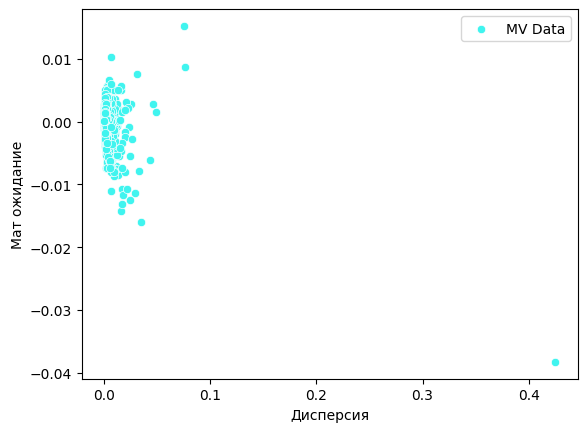

In [ ]:
create_schedule(mv_file)

Чтобы детальнее рассмотреть доходности всех активов, представленных на карте, увеличиваем масштаб графика за счет удаления крайней точки.


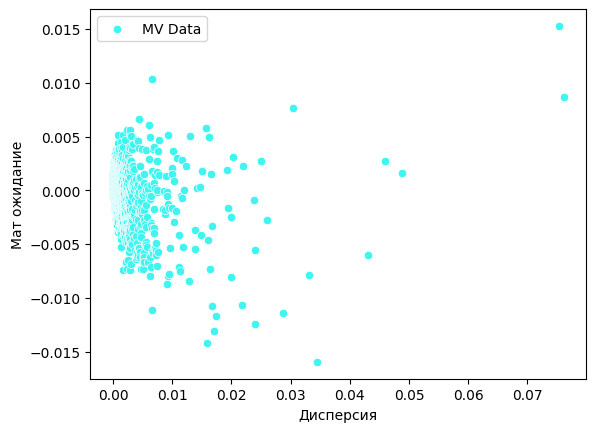

In [ ]:
create_schedule(mv_file)

# 3. Парето оптимальные активы

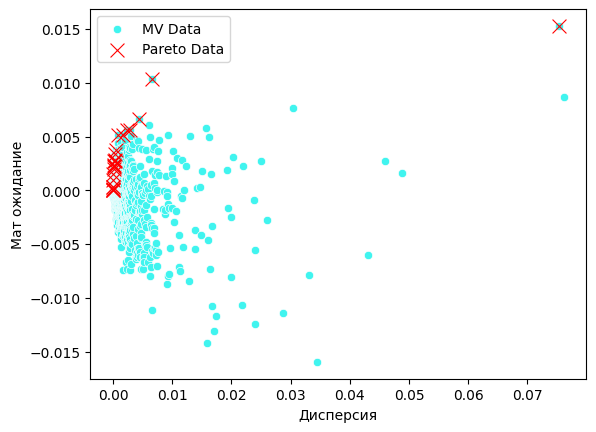

In [ ]:
def find_pareto(xlsx_file_in, xlx_file_out):
    data = pd.read_excel(xlsx_file_in)
    data = data.sort_values(by=['Мат ожидание', 'Дисперсия'], ascending=False).reset_index(drop=True)
    pareto_stocks = []
    previous_var = 100
    for index, stock in data.iterrows():
        if stock['Дисперсия'] <= previous_var and stock['Мат ожидание'] > 0:
            pareto_stocks.append({
                'Название акции': stock['Название акции'],
                'Мат ожидание': stock['Мат ожидание'],
                'Дисперсия': stock['Дисперсия']})
            previous_var = stock['Дисперсия']

    pd.DataFrame(pareto_stocks).to_excel(xlx_file_out, index=False)

pareto_file = 'data/pareto_stocks.xlsx'
if not os.path.exists(pareto_file) or os.stat(pareto_file).st_size == 0:
    find_pareto(mv_file, pareto_file)
create_schedule(mv_file, pareto_file)

# 4. Value at Risk

In [ ]:
def calculate_historical_var(xlsx_file_in, pareto_file_in, xlsx_file_out):
    data = pd.read_excel(xlsx_file_in)
    pareto = pd.read_excel(pareto_file_in)['Название акции']
    vars = []
    for stock in pareto:
        profit = data[stock]
        profit = profit.sort_values().reset_index(drop=True)
        vars.append({'Stocks': stock, 'Var': profit.iloc[12]})  # 95% от года (252)= 12 дней

    vars_pd = pd.DataFrame(vars)
    vars_pd = vars_pd.sort_values('Var', ascending=False).reset_index(
        drop=True)  # самое лучшее по var на 1 месте(если отриц, то теряем, если полож, то получим(почти невозможно))
    vars_pd.to_excel(xlsx_file_out, index=False)


vars_file = 'data/vars.xlsx'
if not os.path.exists(vars_file) or os.stat(vars_file).st_size == 0:
    calculate_historical_var(pr_file, pareto_file, vars_file)

Наиболее предпочтительный актив по Var - CELZ = 0.
* Ожидаемая доходность - 0,015284922;
* Cтандартное отклонение - 0,075369711.

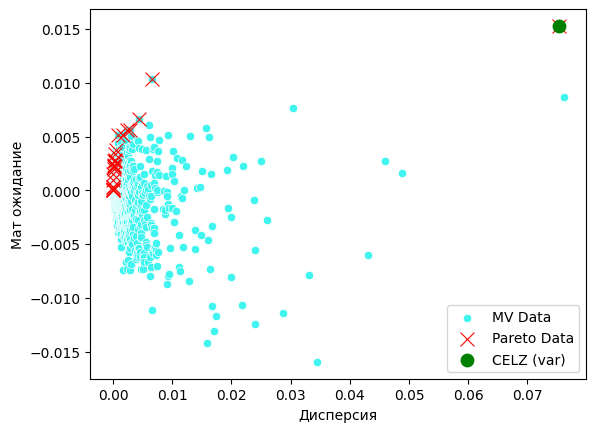

In [ ]:
create_schedule(mv_file, pareto_file)

# 5. Conditional Value at Risk

In [ ]:
def calculate_cvar(xlsx_file_in, pareto_file_in, xlsx_file_out):
    data = pd.read_excel(xlsx_file_in)
    pareto = pd.read_excel(pareto_file_in)['Название акции']
    cvars = []
    for stock in pareto:
        profit = data[stock]
        profit = profit.sort_values().reset_index(drop=True)
        cvars.append({'Stocks': stock, 'Cvar': profit.iloc[0:12].mean()})

    cvars_pd = pd.DataFrame(cvars)
    cvars_pd = cvars_pd.sort_values('Cvar', ascending=False).reset_index(
        drop=True)  # лучшее по cvar на 1 месте, если отриц, то теряем, если положит, то получим
    cvars_pd.to_excel(xlsx_file_out, index=False)

cvars_file = 'data/cvars.xlsx'
if not os.path.exists(cvars_file) or os.stat(cvars_file).st_size == 0:
    calculate_cvar(pr_file, pareto_file, cvars_file)


Наиболее предпочтительный по CVAR - SHV = -0,000375267.
* Ожидаемая доходность - 1,63551E-05;
* Стандартное отклонение -  2,84306E-08.

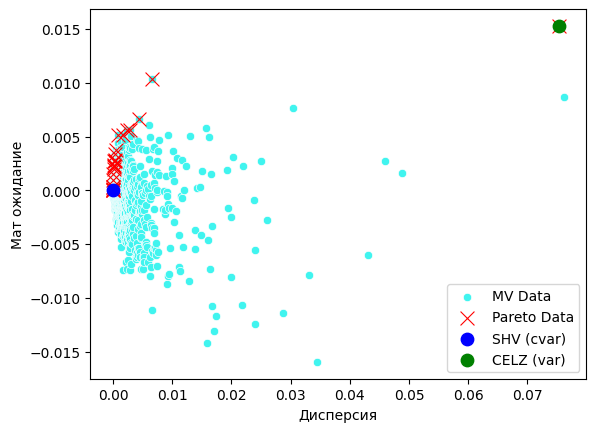

In [ ]:
create_schedule(mv_file, pareto_file)

# 6. Исследование значимых активов рынка

Выбранные активы:

1.   GMGI (GenMedia Partners) - Медиа и реклама. Имеет самое большое стандартное отклонение и самую маленькую ожидаемую доходность;
2.   SNV (iShares Short Treasury Bond) - Финансовые инструменты. Conditional Value at Risk;
3.   CELZ (Celularity) - Биофармацевтика. Value at Risk;
4.   BCDA (BioCardia) - Медицинские технологии. - Вторая по максимально ожидаемой доходности.

In [ ]:
important_dots = ['GMGI', 'SHV', 'CELZ', 'BCDA']

 Выполняем проверку доходностей  на наличие белого шума с использованием анализа инверсий:

In [ ]:
def count_inversions(data):
    inversions = 0
    for i in range(len(data) - 1):
        for j in range(i + 1, len(data)):
            if data[i] > data[j]:
                inversions += 1
    return inversions


def get_left_right_borders(data):
    n = len(data) - 1
    t = 0.062707
    t_n = t * (n ** (3 / 2)) / 6
    left = n * (n - 1) / 4 - t_n
    right = n * (n - 1) / 4 + t_n
    return left, right


def is_white_noise(points, file):
    df = pd.read_excel(file)
    for point in points:
        data = df[point]
        inversions = count_inversions(data)
        left, right = get_left_right_borders(data)
        if inversions > left and inversions < right:
            print(point, ' является белым шумом')
        else:
            print(point, ' не является белым шумом')


is_white_noise(important_dots, pr_file)

GMGI  не является белым шумом
SHV  не является белым шумом
CELZ  не является белым шумом
BCDA  не является белым шумом


В результате анализа ни одна из выбранных точек не является белым шумом,т.е. повторной выборкой из некоторого распределения.

# 7.  Исследование интересных активов рынка из разных производственных секторов

Выбранные активы:
1.   AAPL (Apple) - Технологии;
2.   TSLA (Tesla) - Автомобилестроение, Энергетика;
3.   AZN (AstraZeneca) - Фармацевтика;
4.   TMUS (T-Mobile US) - Телекоммуникации;
5.   LIN (Linde) - Промышленные газы и инжиниринг.



In [ ]:
different_dots = ['AAPL', 'TSLA', 'AZN', 'TMUS', 'LIN']

Выполняем проверку доходностей на соответствие нормальному распределению с использованием функции normaltest(). Интерпретация результата аналогична результатам в критерии Шапиро-Уилка: bpvtybnm

In [ ]:
def is_normal(points, file):
    df = pd.read_excel(file)
    for point in points:
        k2, p = stats.normaltest(df[point][1:])
        if p < 0.05:
            print(point, ' следует нормальному распределению')
        else:
            print(point, ' не следует нормальному распределению')
        print(point, shapiro(df[point][1:]), normaltest(df[point][1:]))
        print('------------------------------------------------')


is_normal(different_dots, pr_file)

AAPL  следует нормальному распределению
AAPL ShapiroResult(statistic=0.9355168099161724, pvalue=4.998507911737326e-09) NormaltestResult(statistic=35.723032322301414, pvalue=1.7492105691269364e-08)
------------------------------------------------
TSLA  следует нормальному распределению
TSLA ShapiroResult(statistic=0.9648133890845616, pvalue=7.75968289892347e-06) NormaltestResult(statistic=34.628268879678146, pvalue=3.023896719450866e-08)
------------------------------------------------
AZN  следует нормальному распределению
AZN ShapiroResult(statistic=0.9347762720404944, pvalue=4.272188827991786e-09) NormaltestResult(statistic=35.9786341885269, pvalue=1.5393552342382538e-08)
------------------------------------------------
TMUS  следует нормальному распределению
TMUS ShapiroResult(statistic=0.9245001960309253, pvalue=5.376330958002586e-10) NormaltestResult(statistic=36.282889467294844, pvalue=1.3221193408396438e-08)
------------------------------------------------
LIN  следует нормально

Строим плотность нормального распределения и гистограмму:

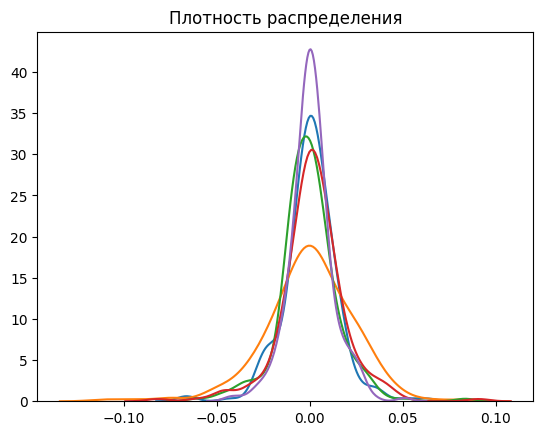

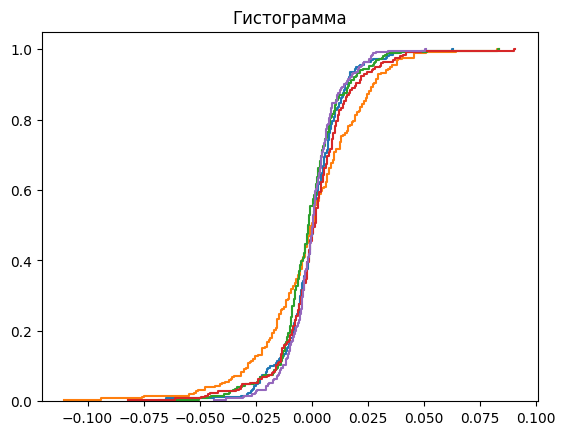

In [ ]:
def kdeplt(points, file):
    df = pd.read_excel(file)
    for point in points:
        sns.kdeplot(data=df[point][1:], common_norm=False)

    plt.xlabel('')
    plt.ylabel('')
    plt.title('Плотность распределения')
    plt.show()


def histplt(points, file):
    df = pd.read_excel(file)
    for point in points:
        sns.histplot(data=df[point][1:], bins=len(df[point][1:]), stat="density", element="step", fill=False,
                     cumulative=True, common_norm=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Гистограмма')
    plt.show()


kdeplt(different_dots, pr_file)
histplt(different_dots, pr_file)

Из графиков видно, что распределение соответсвует нормальному, что подверждает результаты тестов.

# 8. Дополнительные исследования рынка




Анализируем волатильность, которая может помочь определить, какие акции наиболее подвержены колебаниям цен:

In [ ]:
def count_volatility(points, file):
    df = pd.read_excel(file)
    for point in points:
        volatility = df[point].std()
        print(f'{point}: Стандартное отклонение доходностей: {volatility}')


count_volatility(different_dots, pr_file)


AAPL: Стандартное отклонение доходностей: 0.01475269333229638
TSLA: Стандартное отклонение доходностей: 0.024239444743517025
AZN: Стандартное отклонение доходностей: 0.015754390594872186
TMUS: Стандартное отклонение доходностей: 0.017586488172073197
LIN: Стандартное отклонение доходностей: 0.011796001581602867


Среди всех активов стоимость TSLA наиболее подвержена колебаниям.

Находим аномальные значения, используя IQR (межквартильный размах), что помогает выявить резкие ценовые скачки или падения, которые выходят за рамки нормальных колебаний рынка:

In [ ]:
def find_anomalies(points, file):
    df = pd.read_excel(file)
    for point in points:
        q1 = df[point].quantile(0.25)
        q3 = df[point].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        anomalies = (df[point] < lower) | (df[point] > upper)
        print(f'Обнаруженные аномалии:\n{anomalies}')
        print('------------------------------------------------')


find_anomalies(different_dots, pr_file)

Обнаруженные аномалии:
0      False
1      False
2      False
3       True
4      False
       ...  
247    False
248    False
249    False
250    False
251    False
Name: AAPL, Length: 252, dtype: bool
------------------------------------------------
Обнаруженные аномалии:
0      False
1      False
2      False
3      False
4      False
       ...  
247    False
248    False
249    False
250    False
251    False
Name: TSLA, Length: 252, dtype: bool
------------------------------------------------
Обнаруженные аномалии:
0      False
1      False
2      False
3       True
4      False
       ...  
247    False
248    False
249    False
250    False
251    False
Name: AZN, Length: 252, dtype: bool
------------------------------------------------
Обнаруженные аномалии:
0      False
1      False
2      False
3      False
4      False
       ...  
247    False
248    False
249    False
250    False
251    False
Name: TMUS, Length: 252, dtype: bool
------------------------------------------

Акции TMUS и TSLA не были подвержены выбросам, следовательно не было никаких аномальных скачков и движения цен. При этом у акции: APPL, AZN, LIN цена в 3-4 день вышла за предел нормального диапазона. Возможно, причиной этому была какая-то новость или паника на рынке. При этом в остальные дни акции все так же относительно стабильны.